# Advanced Image Processing (TM11005)
*Week 3: Machine learning and Pattern Recognition
Exercise 2, Lecture 3: Radiomics*

@author: Martijn Starmans

In this exercise, you will learn all about radiomics. The following
methods steps be covered:
- Data Collection
- Preprocessing
- Segmentation
- Feature extraction
- Machine learning
- Evaluation


## DATA
We will make use of the following data sets:

- Toy samples from sklearn: see
  http://scikit-learn.org/stable/datasets/index.html for more information
  on the datasets.
- MR scans of patients with Low Grade Glioma (LGG) from
  https://wiki.cancerimagingarchive.net/display/Public/LGG-1p19qDeletion and
  segmentations from https://data.mendeley.com/datasets/rssf5nxxby/1, used
  in these papers: https://arxiv.org/pdf/1611.06939.pdf, 
  https://clincancerres.aacrjournals.org/content/25/24/7455.abstract


Description:
    Low Grade Glioma's (LGGs) are a specific group of cancerous brain tumors.
    Research has shown that patients with a specific genetic mutation, the
    1p/19q co-deletion, have a better survival and prognosis than patients
    who do not have this mutation.

The genetic status of a patient can only
    be obtained after taking a biopsy, followed by genetic sequencing. This
    procedure is invasive, brings risks to the patients and relatively high
    in costs.

There is therefore a major interest in trying to predict the 1p19q status
    solely based on MR scans. You are also going to try this the coming week.

This dataset consists of two MR scans per patiet (T1 and T2) plus a
    segmentation of the three middle slices of the tumor on the T2.

## Important Note
We will use the word "labels" in two contexts.

Each feature has a specific name, for example histogram_mean. We will refer
to the names of features as feature_labels.

We will encounter several datasets with various objects. These objects often
corresponds with patients, e.g. the dataset with brain MRI scans from various
patients. These patients also have "labels": these correspond to the class the
objects belongs to. For example, for the LGG dataset, each patient has the
label 0 or 1, indicating whether they have the 1p/19q co-deletion or not.

## **Handing in your answers**
For each exercise, you have to hand in answers to questions, and
for some also the code. Hence please only hand in two files in total
for this exercise set:

- Code.py (or .docx): a Python script / Text file containing all the code you are requested to hand in.
- Answers.docx (or .PDF): a text file with the answers to the
questions (plots, text, ...).

**Important Note:** Exercises 1, 2, 4, 6, and 7 are mandatory, plus exercise 3 OR exercise 5. In the later questions, if you decide to skip exercise 3, you can skip the parts related to that exercise, and similar for exercise 5.

## Start

In [2]:
# Let's first install the neccesary packages
!pip install numpy pandas SimpleITK scikit-image natsort scikit-learn seaborn PREDICT matplotlib

# NOTE: if you get an error when installing PREDICT concerning pywavelets,
# you can just negate it

# Install the toolbox we made for this course
!pip install -q --upgrade git+https://github.com/MStarmans91/aiptoolbox.git

     |████████████████████████████████| 47.4MB 99kB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 194kB 45.5MB/s 
     |████████████████████████████████| 1.9MB 39.4MB/s 
     |████████████████████████████████| 4.3MB 36.5MB/s 
     |████████████████████████████████| 112kB 42.0MB/s 
     |████████████████████████████████| 552kB 38.4MB/s 
  Created wheel for phasepack: filename=phasepack-1.5-cp37-none-any.whl size=26983 sha256=a432c46987f5e3bcb708c66f582dc0f832e2b729c1fac8c1de0cdef9e4927598
  Stored in directory: /root/.cache/pip/wheels/70/b3/0a/eba59071a075d1192016960030f2b52751f23adfb260a3db93
Successfully built phasepack
ERROR: predict 3.1.13 has requirement PyWavelets<=1.0.0,>=0.4.0, but you'll have pywavelets 1.1.1 which is incompatible.
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
# Again, we start by importing all neccesary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import SimpleITK as sitk
import glob
import os
import pydicom
import pandas as pd

# Feature selection
from aip.StatisticalTestThreshold import StatisticalTestThreshold

# Feature extraction
from PREDICT.imagefeatures.histogram_features import get_histogram_features
from PREDICT.imagefeatures.shape_features import get_shape_features
from PREDICT.imagefeatures.texture_features import get_LBP_features, get_GLCM_features,\
    gabor_filter_parallel
from PREDICT.helpers import image_helper as ih

# Machine learning: minimum distance classifier is called NearestCentroid in sklearn
from sklearn.neighbors import NearestCentroid as MinimumDistance
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# The AIP package
import aip

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/phasepack/tools.py:14: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  'fftpack' module for 2D Fourier transforms.""")


## 1. Data Collection
We will use the LGG dataset for this exercise as well. We have already
downloaded a subset of 30 patients, which can de found in the Data folder.
Upon receiving a dataset, your first step should always be to analyze it
and get an idea of what the various parameters (e.g. acquisition paramaters)
in your dataset are.

Normally, imaging data comes in the DICOM (.dcm) format. All the scanner
parameters are stored in there. However, DICOM can be very inconvenient to
work with: each slice is in a different file, plus all the parameters cost
a lot of memory. Hence, in image processing, we always convert the DICOMs to
a more convenient format such as Nifti (.nii or .nii.gz). This we already
did for you.

For each patient, you should have the following files:
- A Nifti with the T1 Scan
- A Nifti with the T2 Scan, already registered with the T1
- A single DICOM file belonging to the first slice of the T1 scan
- A single DICOM file belonging to the first slice of the T2 scan
- A segmentation of the brain
- A segmentation of the three tumor slices in the middle of the tumor, according to the paper of Akkus et al. 2016
- A segmentation of the full tumor, according to van der Voort et al. 2019


In [4]:
# Get an overview of the full LGG dataset and the labels
LGG_data, LGG_labels = aip.list_data()

patient_ids = LGG_data.keys()
for pid in patient_ids:
    print(f'{pid}: {LGG_data[pid]}.')

print(LGG_labels)

LGG-104: {'T1_image': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/T1.nii.gz', 'T2_image': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/T2.nii.gz', 'Segmentation_full': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/Full_segmentation.nii.gz', 'Segmentation_slices': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/Segmentation.nii.gz', 'T1_metadata': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/00000_T1.dcm', 'T2_metadata': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/00000_T2.dcm'}.
LGG-246: {'T1_image': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-246/T1.nii.gz', 'T2_image': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-246/T2.nii.gz', 'Segmentation_full': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-246/Full_segmentation.nii.gz', 'Segmentation_slices': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG-246/Segmentation.nii.gz', 'T1_metadata': '/usr/local/lib/python3.7/dist-packages/aip/data/LGG


To analyze the scan parameters, let's take a look at the DICOMs of the T1 scans.

In [5]:
Dicom_file_list = [LGG_data[pid]['T1_metadata'] for pid in patient_ids]
Dicom_file_list.sort()

# Load and print the first DICOM to the command line
dicom = pydicom.read_file(Dicom_file_list[0])
print(dicom)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.3344.2526.297543010293189724140766218400
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.3344.2526.297543010293189724140766218400
(0008, 0020) Study Date       

You can see that the DICOM contains a lot of information. Let's for now
focus on some parameters that can have a major impact on the image itself,
and thus on the features extracted from it:
- 0x18, 0x50: the slice thickness
- 0x18, 0x87: the magnetic field strenght
- 0x8, 0x1010: the manufacturer
- 0x28, 0x30: the pixel spacing

In [6]:
# You can extract the value of a tag in the following way:
slice_thickness = dicom[0x18, 0x50].value
print(f'Slice Thickness: {slice_thickness}.')

Slice Thickness: 3.


## Exercise 1: Data analysis

- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. Extract the values of the four DICOM tags mentioned above from all
  the DICOM files. Note: the patient ID is in tag 0x10, 0x20!

2. Create a histogram or violin plot of the values. Hint: use the ```aip.other.make_violin_plot``` function! **Question:** What do you notice? Considering the
  feature extraction in the next step, what (preprocessing) methods would
  you use to deal with this? 



In [11]:
dicom_tags = {}
slice_thickness = []
magnetic_field_strength = []
manufacturer = []
pixel_spacing = []

for file in Dicom_file_list:
    print(file)
    temp_dicom = pydicom.read_file(file)
   
    slice_thickness.append(temp_dicom[0x18, 0x50].value)
    magnetic_field_strength.append(temp_dicom[0x18, 0x87].value)
    try:
      manufacturer.append(temp_dicom[0x8, 0x1010].value)
    except Exception as e:
      manufacturer.append("")
    pixel_spacing.append(temp_dicom[0x28, 0x30].value)

dicom_tags["slice_thickness"] = slice_thickness
#
dicom_tags["magnetic_field_strength"] = magnetic_field_strength
#dicom_tags["manufacturer"] = manufacturer
#dicom_tags["pixel_spacing"] = pixel_spacing

/usr/local/lib/python3.7/dist-packages/aip/data/LGG-104/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-246/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-261/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-273/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-274/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-278/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-285/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-286/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-293/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-297/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-311/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-326/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-327/00000_T1.dcm
/usr/local/lib/python3.7/dist-packages/aip/data/LGG-330/00000_T1.dcm
/usr/local/lib/python3.7/dist-pack

In [15]:
dicom_tags["slice_thickness"]

["3.0",
 "3.0",
 "3.0",
 "5.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "5.0",
 "3.0",
 "4.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0",
 "3.0"]

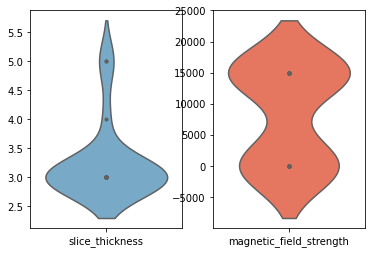

In [14]:
aip.other.make_violin_plot(dicom_tags)

## Exercise 2: Segmentation

- **Hand-In Code**: None.
- **Hand-In Answers**: Answer.

We gave you two tumor segmentations per patient: three slices centered around
the largest slice, and the full tumor. Which one(s) you take is up to you.
**Question:** Please however motivate your choice, and verify later on (exercise 6)
whether this indeed was a good choice or not.

## Exercise 3: Preproccessing

- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

In the lecture, we have seen that preprocessing can help to deal with 
variations in the data. Apply the preprocessing steps you think are neccesary
to this dataset. **Question:** Please provide a good motivation for why you performed
certain steps!

Hints: you may want to use the ```sitk.Normalize``` and ```aip.other.resample_images``` functions.
Hints: optionally, you may use one or multiple masks here.
Hints: as the T1 and T2 for each patient are registered, they have the same
       pixel spacing and slice thickness!

In [ ]:
# You can use the code below as a start if you want
def apply_preprocessing(inputimage, outputimage, ismask=False):
    """Define the preprocessing to apply per patient."""
    # Load image
    image = sitk.ReadImage(inputimage)
    # Apply preprocessing  
    # Hint: you may want to apply different preprocessing for masks than for the images
    normalized_image = sitk.Normalize(image)
    # Write output
    sitk.WriteImage(image, outputimage)     

for pid in patient_ids:
  print(f'Preprocessing {pid}')
  print('\t T1')
  output = LGG_data[pid]['T1_image'].replace('.nii.gz', '_preprocessed.nii.gz')
  apply_preprocessing(LGG_data[pid]['T1_image'], output)

  print('\t T2')
  output = LGG_data[pid]['T2_image'].replace('.nii.gz', '_preprocessed.nii.gz')
  apply_preprocessing(LGG_data[pid]['T2_image'], output)

  # Depending on exercise 2, choose one of the segmentations below
  print('\t Full segmentation')
  output = LGG_data[pid]['Segmentation_full'].replace('.nii.gz', '_preprocessed.nii.gz')
  apply_preprocessing(LGG_data[pid]['Segmentation_full'], output, ismask=True)

  print('\t Slices segmentation')
  output = LGG_data[pid]['Segmentation_slices'].replace('.nii.gz', '_preprocessed.nii.gz')
  apply_preprocessing(LGG_data[pid]['Segmentation_slices'], output, ismask=True)

print('Done!')

Preprocessing LGG-104
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-246
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-261
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-273
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-274
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-278
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-285
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-286
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-293
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-297
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-311
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-326
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-327
	 T1
	 T2
	 Full segmentation
	 Slices segmentation
Preprocessing LGG-330
	 T1
	 T2
	 Full

    
## Exercise 4: Feature extraction


- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. Inspect the images visually.
   **Question:** What kind of features do you think are "good" for this application?

  Hint: remember the ```aip.other.slicer``` function from the Monday exercise.



In [ ]:
# Your code for part 1

2. Extract those features for all patients using the scripts from the
  the Monday exercise using the ```PREDICT``` toolbox, which we already imported here as well.

Hint: you may want to again use the ```ih.get_masked_voxels``` and 
  ```ih.get_masked_slices_image``` functions for the histogram and 
  texture features, respectively.

Hint: save the features in a file (e.g. .hdf5 with pandas, .json, .csv) so
  you don't have to run this multiple times! 

In [ ]:
# Example on how you can save your features easily
example_feature_values = [1, 2, 3]
example_feature_labels = ['label1', 'label2', 'label3']

# Convert to panda series and save
panda_data = pd.Series([example_feature_values, example_feature_labels],
                        index=['feature_values', 'feature_labels'],
                        name='Image features'
                      )
        
output = 'example_features.hdf5'
panda_data.to_hdf(output, 'image_features') 

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  encoding=encoding,


## Feature selection

 As seen in the lecture, the Mann-Whitney U test can be used as feature
 selection method by only selecting features with a low (e.g. < 0.05)
 p-value. We have implemented this in the StatisticalTestThreshold object.


In [ ]:
# Let's create an example dataset to test this on. For this,
# we will use the sklearn make_classification function:
X1, Y1 = ds.make_classification(n_samples=100, n_features=3, n_redundant=1,
                                n_informative=2,
                                n_clusters_per_class=1)

Note that we added one redundant feature, which should be de-selected. Also,
note the format of the features 
(X1, numpy array, columns=features, rows=patients) and the labels
(Y1, numpy array)

In [ ]:
# Create a selector object
selector = StatisticalTestThreshold()

# Fit on the dataset
selector.fit(X1, Y1)

# We can check the metric values of each features:
print(selector.metric_values)

# and the indices of the features that got selected:
print(selector.selectrows)

[7.37089185708476e-16, 0.2572045286867708, 6.590736485265207e-16]
[0, 2]


It may be that your redundant feature got remove, but maybe not. If the
feature has similar distributions in both classes, it will be removed. 
However, if it is redundant because it is similar to another feature, but 
does have a different distribution in both classes, it will not be removed.


In [ ]:
# You can apply the found feature selection method through the transform function
X1 = selector.transform(X1)

Note: if you remove features values, also make sure you remove the corresponding
feature labels! You can use the same transform function for this.


## Exercise 5: Feature selection

- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. You are going to apply feature selection to the LGG dataset. **Question:** Which 
  parameters will you use, e.g. p-value threshold and yes/no Bonferonni correction?
  The StatisticalTestThreshold can also apply a Student t-test, Welch t-test, or
  Wilcoxon signed-rank test. Why is the Mann-Whitney U test most suitable here?
  The descriptions on Wikipedia of these tests can be helpful. 

Hint: look at what distributions the tests assume, whether they are paired
  or not, and parametric or non-parametric. 
    
2. Fit a selector to your features, both T1 and T2. Look at the p-values
  and which features get selected. **Question:** What do you think of the results? Did
  these features correspond with your hypothesis? What kind of imaging
  characteristics do these features correspond to? Do you think these
  features are good features? You picked a specific segmentation: do
  you think these features will server from observer variations if the
  segmentation if you would let a another radiologist perform the same type
  of segmentation? Do you think your features may be biased through the
  segmentation protocol?

3. To prepare for the next exercise, create a dataset on which you apply
  the transform for the selector, both on the features and the labels. Make
  sure you save this as separate variables, as you will also need the 
  "Unselected" dataset.    

In [ ]:
# Room for your code for exercise 5

# An introduction to machine learning with Python
The default package for machine learning in Python is called scikit-learn
or sklearn for short. In the TM10007 Machine Learning course, you will 
learn much more about what this package has to offer. Here, we will just use
a very small amount of the routines.

In [ ]:
# Let's make a dataset with only two features, which is easier for plotting
X1, Y1 = ds.make_classification(n_samples=100, n_features=2, n_redundant=0,
                                n_informative=2,
                                n_clusters_per_class=1)

The results are the features (X1, 2 per object in this case) and the labels.
Note the parameters used to create the sample. The function has a random
aspect, hence you will get a different result every time you run it. 

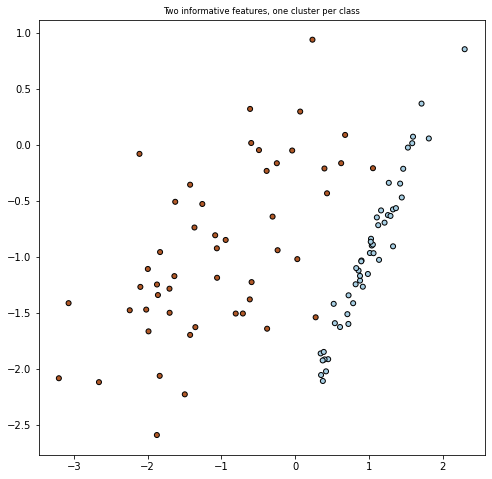

In [ ]:
# Now let's make a scatterplot of the features:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative features, one cluster per class",
             fontsize='small')
ax.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
           s=25, edgecolor='k', cmap=plt.cm.Paired)

These features are highly distinctive: hence it should be easy to split
the classes. Let's therefore start out with a simple classifier:
the Minimum Distance classifier, as we saw in the lecture.

In [ ]:
classifier = MinimumDistance()

The classifiers share many of the same attributes in sklearn.
One of the default functions is the ```fit``` function, which fits the
classifier using features and labels. This will result in a
fitted classifier. 

In [ ]:
# Let's try it on our example dataset:
classifier.fit(X1, Y1)

NearestCentroid(metric='euclidean', shrink_threshold=None)

The fitted classifier can be used to predict the labels on features of
another object or patient. You can hereby use your trained classifiers
on other datasets. For now, let's just use it again on the training set.
The result will in this case be predicted binary labels, as we
trained a binary classifier

0.27498004514012614
Number of mislabeled points out of a total 100 points : 9


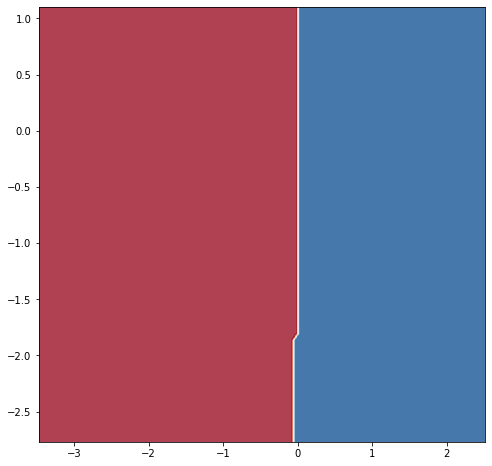

In [ ]:
# Make a prediction
y_pred = classifier.predict(X1)

# Let's see how well our classifier performed. We wrote a functions that
# overlays the decision boundary with a color plot. Also, let's print
# the total number of misclassifications
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
aip.other.colorplot(classifier, ax, X1[:, 0], X1[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X1.shape[0], (Y1 != y_pred).sum()))


Hopefully, your classifier performed well enough.

## Feature preprocessing
Note that all features have a different range: one might be between 0 and 1,
another between 1E6 and 1E7. The minimumdistance classifier will negate
these small features, while they may be important. Hence, before you apply
the classifier to your own feautures, scale them to the same range. For
that purpose, we can apply normalization through z-scoring, as we also
did for the images. You will learn more about this in the machine learning
course: for now, just make sure you apply it before classification!


In [ ]:
# Usage is again through the fit-transform construction.
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

As the features from the make_classification function are properly scaled,
it won't make so much of a difference there.

## Exercise 6: Machine learning for radiomics

- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

1. Apply, i.e. train and test/predict, the MinimumDistance classifier to 
  your feature selected dataset. **Question:** How does it perform? Which patients
  did go wrong: what do you notice? What would you 
  suggest to improve the performance?
    
2. Apply the MinimumDistance classifier to your dataset without feature
  selection. **Question:** What happens? Why? 

In [ ]:
# Room for your code for exercise 6

## Exercise 7: Evaluation

- **Hand-In Code**: all.
- **Hand-In Answers**: The generated plots and answers to the questions.

You probably got a very good performance in your previous exercise, both
with and without feature selection. However, we were overfitting: we used
the same samples for both training and testing. Let's now use a
k-fold cross-validation, which in sklearn is implemented in the KFold object.


In [ ]:
crossvalidation = KFold()

1. **Question:** Which numer of splits would you use here and why?

2. Implement the cross-validation: for help, look into the sklearn online
  documentation. **Question:** Which parts of the method from above
  do need to be fit on the training dataset only? Compute again the total
  number of mislabeled points, both with and without feature selection. How
  do the results compare to the previous exercise?

3. Earlier on, in exercise 2, you were required to pick one (or multiple) segmentations 
  from which you extracted the features and made a hypothesis why that
  was a good choice. **Question:** What do you think know: was that indeed a good choice?
  Why (not)?

In [ ]:
# Room for your code for exercise 7